In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read in datafile

In [2]:
#pd.set_option('display.max_columns', None)
df = pd.read_csv("rawJailDataIntern.csv")

In [3]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,fips,facility_name,year,rated_capacity,total_confined_pop,adp,confined_women,confined_men,admissions_year,admissions_week,admissions_day,discharge_year,discharge_week,discharge_day
0,6059,ORANGE COUNTY SHERIFF'S DEPARTMENT,1985,1864.0,2844.0,2767.0,364,2476.0,93086.0,NaN,NaN,92834.0,NaN,NaN
1,6059,ORANGE COUNTY SHERIFF'S DEPARTMENT,1986,2496.0,3217.0,2913.0,375,2842.0,93998.0,NaN,NaN,93642.0,NaN,NaN
2,6059,ORANGE COUNTY SHERIFF'S DEPARTMENT,1987,2775.0,3471.0,3250.0,464,3006.0,77747.0,NaN,NaN,76685.0,NaN,NaN
3,6059,ORANGE COUNTY SHERIFF'S DEPARTMENT,1989,3478.0,4527.0,4281.0,585,3942.0,125325.0,NaN,NaN,122631.0,NaN,NaN
4,6059,ORANGE COUNTY SHERIFF'S DEPARTMENT,1990,3478.0,4402.0,4370.0,510,3892.0,92899.0,NaN,NaN,93416.0,NaN,NaN
5,6059,ORANGE COUNTY SHERIFF'S DEPARTMENT,1992,5289.0,4690.0,4688.0,495,4181.0,NaN,NaN,223.0,NaN,NaN,244.0
6,6059,ORANGE COUNTY SHERIFF'S DEPARTMENT,1994,3821.0,4987.0,4836.0,539,4434.0,NaN,NaN,NaN,NaN,NaN,NaN
7,6059,ORANGE COUNTY SHERIFF'S DEPARTMENT,1995,3821.0,5157.0,5074.0,620,4522.0,NaN,NaN,NaN,NaN,NaN,NaN
8,6059,ORANGE COUNTY SHERIFF'S DEPARTMENT,1996,3821.0,5326.0,5143.0,673,5068.0,NaN,NaN,NaN,NaN,NaN,NaN
9,6059,ORANGE COUNTY SHERIFF'S DEPARTMENT,1997,3821.0,5368.0,5246.0,716,4635.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# count missing data
initial_missing_ay = df.admissions_year.isna().sum()
initial_missing_dy = df.discharge_year.isna().sum()

In [5]:
df['county'] = df['facility_name'].str.split(' ').str[0]

df

,fips,facility_name,year,rated_capacity,total_confined_pop,adp,confined_women,confined_men,admissions_year,admissions_week,admissions_day,discharge_year,discharge_week,discharge_day,county
0,6059,ORANGE COUNTY SHERIFF'S DEPARTMENT,1985,1864.0,2844.0,2767.0,364,2476.0,93086.0,NaN,NaN,92834.0,NaN,NaN,ORANGE
1,6059,ORANGE COUNTY SHERIFF'S DEPARTMENT,1986,2496.0,3217.0,2913.0,375,2842.0,93998.0,NaN,NaN,93642.0,NaN,NaN,ORANGE
2,6059,ORANGE COUNTY SHERIFF'S DEPARTMENT,1987,2775.0,3471.0,3250.0,464,3006.0,77747.0,NaN,NaN,76685.0,NaN,NaN,ORANGE
3,6059,ORANGE COUNTY SHERIFF'S DEPARTMENT,1989,3478.0,4527.0,4281.0,585,3942.0,125325.0,NaN,NaN,122631.0,NaN,NaN,ORANGE
4,6059,ORANGE COUNTY SHERIFF'S DEPARTMENT,1990,3478.0,4402.0,4370.0,510,3892.0,92899.0,NaN,NaN,93416.0,NaN,NaN,ORANGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,56043,WASHAKIE COUNTY DETENTION CENTER,1978,10.0,1.0,NaN,0,1.0,NaN,3.0,NaN,NaN,3.0,NaN,WASHAKIE
163,56043,WASHAKIE COUNTY DETENTION CENTER,1983,10.0,3.0,NaN,1,2.0,413.0,NaN,NaN,413.0,NaN,NaN,WASHAKIE
164,56043,WASHAKIE COUNTY DETENTION CENTER,1988,56.0,12.0,9.0,1,10.0,543.0,NaN,NaN,537.0,NaN,NaN,WASHAKIE
165,56043,WASHAKIE COUNTY DETENTION CENTER,1993,42.0,14.0,16.0,1,13.0,NaN,NaN,NaN,NaN,NaN,NaN,WASHAKIE


In [6]:
# interpolate missing admissions_year data based on admissions_week and admissions_day
df['admissions_year'] = np.where(df.admissions_year.isnull(), df.admissions_week * 52, df.admissions_year)
df['admissions_year'] = np.where(df.admissions_year.isnull(), df.admissions_day * 365, df.admissions_year)

# interpolate missing discharge_year data based on discharge_week and discharge_day
df['discharge_year'] = np.where(df.discharge_year.isnull(), df.discharge_week * 52, df.discharge_year)
df['discharge_year'] = np.where(df.discharge_year.isnull(), df.discharge_day * 365, df.discharge_year)

In [7]:
# missing data in admissions_year
print("There were ", initial_missing_ay, " initial missing values for admissions per year. Now, there are ", df.admissions_year.isna().sum(), " missing in that column.")
print("There were ", initial_missing_dy, " initial missing values for discharges per year. Now, there are ", df.discharge_year.isna().sum(), " missing in that column.")


There were  122  initial missing values for admissions per year. Now, there are  39  missing in that column.
There were  122  initial missing values for discharges per year. Now, there are  40  missing in that column.


# Make all admissions and discharge data comparable on the year level and drop weekly and daily data

In [8]:
# Select identifying columns and admissions/discharge counts for year
df = df[['county', 'year', 'admissions_year', 'discharge_year']]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,county,year,admissions_year,discharge_year
0,ORANGE,1985,93086.0,92834.0
1,ORANGE,1986,93998.0,93642.0
2,ORANGE,1987,77747.0,76685.0
3,ORANGE,1989,125325.0,122631.0
4,ORANGE,1990,92899.0,93416.0
5,ORANGE,1992,81395.0,89060.0
6,ORANGE,1994,NaN,NaN
7,ORANGE,1995,NaN,NaN
8,ORANGE,1996,NaN,NaN
9,ORANGE,1997,NaN,NaN


In [18]:
# Pivot to make admissions and discharge data comparable on the year level
admissions_plot = (df.drop(columns=['discharge_year'])
                   .pivot(index='year', columns='county', values = 'admissions_year'))
admissions_plot

county,ADAMS,BALLARD,BARREN,BRISTOL,COLLIER,MARION,ORANGE,PUTNAM,WASHAKIE,YORK
year,,,,,,,,,,
1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978,156.0,NaN,NaN,NaN,NaN,NaN,NaN,4420.0,156.0,NaN
1983,138.0,1230.0,NaN,NaN,NaN,NaN,NaN,2892.0,413.0,208.0
1985,NaN,NaN,NaN,1605.0,10595.0,12000.0,93086.0,NaN,NaN,NaN
1986,NaN,NaN,NaN,1804.0,11483.0,13200.0,93998.0,NaN,NaN,NaN
1987,NaN,NaN,NaN,1975.0,8098.0,11158.0,77747.0,NaN,NaN,NaN
1988,119.0,345.0,NaN,NaN,NaN,NaN,NaN,3000.0,543.0,735.0
1989,NaN,NaN,NaN,2085.0,11121.0,11549.0,125325.0,NaN,NaN,NaN
1990,NaN,NaN,NaN,2439.0,11212.0,11600.0,92899.0,NaN,NaN,NaN


array([[<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>],
       [<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>]], dtype=object)

<Figure size 640x480 with 0 Axes>

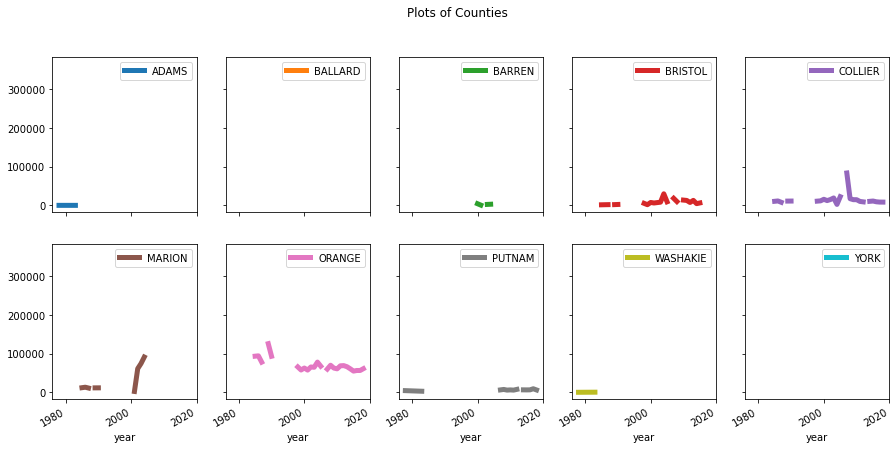

In [23]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

admissions_plot.plot(subplots = True, 
                layout = (2, 5),
               sharey = True,
               title = "Plots of Counties",
               linewidth = 5,
                figsize=(15,7))

# Write code that identifies anomalies in the data (for example, depending on the spread of the data, we often use a 20-40% year over year change threshold to find anomalies, feel free to use this or your own way to find anomalies)

In [11]:
percentages = df[['admissions_year', 'discharge_year']].pct_change()
percentages = percentages.rename(columns={"admissions_year": "pct_admissions_change", "discharge_year": "pct_discharge_change"})
df = df.join(percentages)
df

,county,year,admissions_year,discharge_year,pct_admissions_change,pct_discharge_change
0,ORANGE,1985,93086.0,92834.0,NaN,NaN
1,ORANGE,1986,93998.0,93642.0,0.009797,0.008704
2,ORANGE,1987,77747.0,76685.0,-0.172887,-0.181083
3,ORANGE,1989,125325.0,122631.0,0.611959,0.599152
4,ORANGE,1990,92899.0,93416.0,-0.258735,-0.238235
...,...,...,...,...,...,...
162,WASHAKIE,1978,156.0,156.0,-0.974765,-0.980645
163,WASHAKIE,1983,413.0,413.0,1.647436,1.647436
164,WASHAKIE,1988,543.0,537.0,0.314770,0.300242
165,WASHAKIE,1993,NaN,NaN,0.000000,0.000000


In [12]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,county,year,admissions_year,discharge_year,pct_admissions_change,pct_discharge_change
0,ORANGE,1985,93086.0,92834.0,NaN,NaN
1,ORANGE,1986,93998.0,93642.0,0.009797,0.008704
2,ORANGE,1987,77747.0,76685.0,-0.172887,-0.181083
3,ORANGE,1989,125325.0,122631.0,0.611959,0.599152
4,ORANGE,1990,92899.0,93416.0,-0.258735,-0.238235
5,ORANGE,1992,81395.0,89060.0,-0.123833,-0.046630
6,ORANGE,1994,NaN,NaN,0.000000,0.000000
7,ORANGE,1995,NaN,NaN,0.000000,0.000000
8,ORANGE,1996,NaN,NaN,0.000000,0.000000
9,ORANGE,1997,NaN,NaN,0.000000,0.000000


In [13]:
adm_mess = df.loc[(df['pct_admissions_change'] > .40) | (df['pct_admissions_change'] < -.40)]
adm_mess_indices = list(adm_mess.index.values)

df_remove_anomalies = df.drop(adm_mess_indices).dropna(subset=['admissions_year'])[['county','year','admissions_year']]

df_pivoted = df_remove_anomalies.pivot(columns = 'county', index = 'year', values = 'admissions_year')
df_pivoted

county,ADAMS,BALLARD,BARREN,BRISTOL,COLLIER,MARION,ORANGE,PUTNAM,WASHAKIE,YORK
year,,,,,,,,,,
1983,138.0,NaN,NaN,NaN,NaN,NaN,NaN,2892.0,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,93086.0,NaN,NaN,NaN
1986,NaN,NaN,NaN,1804.0,11483.0,13200.0,93998.0,NaN,NaN,NaN
1987,NaN,NaN,NaN,1975.0,8098.0,11158.0,77747.0,NaN,NaN,NaN
1988,119.0,NaN,NaN,NaN,NaN,NaN,NaN,3000.0,543.0,NaN
1989,NaN,NaN,NaN,2085.0,11121.0,11549.0,NaN,NaN,NaN,NaN
1990,NaN,NaN,NaN,2439.0,11212.0,11600.0,92899.0,NaN,NaN,NaN
1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,903.0
1992,NaN,NaN,NaN,1825.0,8395.0,NaN,81395.0,NaN,NaN,NaN


array([[<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>],
       [<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
        <AxesSubplot:xlabel='year'>]], dtype=object)

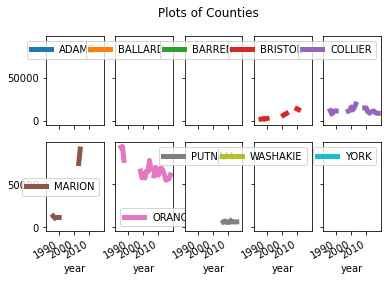

In [14]:
df_pivoted.plot(subplots = True, 
                layout = (2, 5),
               sharey = True,
               title = "Plots of Counties",
               linewidth = 5)

(-58204.57307478941, 109145.38557478941)


<AxesSubplot:>

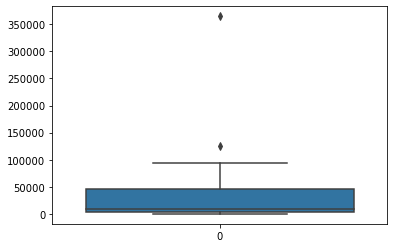

In [15]:
def find_bounds(data):
    """
    Based on a distribution, return upper and lower bounds (3 standard deviations from the mean or more).
    """
    anomalies = []
    
    mean = data.mean()
    std = data.std()
    
    lower_limit = mean - 2 * std
    upper_limit = mean + 2 * std
    
    return lower_limit, upper_limit

print(find_bounds(df['admissions_year']))

sns.boxplot(data=df['admissions_year'])

<AxesSubplot:>

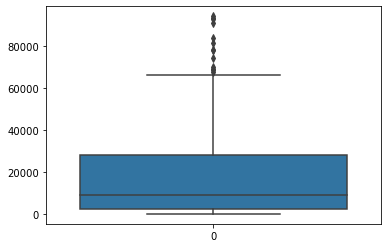

In [16]:
new_df = df.loc[df['admissions_year'] < find_bounds(df['admissions_year'])[1]]

sns.boxplot(data=new_df['admissions_year'])

In [17]:
print(find_anomalies(df['discharge_year']))
sns.boxplot(data=df['discharge_year'])

NameError: name 'find_anomalies' is not defined

In [ ]:
def findAnomalies(df, colname):
    anomalies = []
    for (county, year) in df.iteritems():
        print(year)
        
findAnomalies(df, 'admissions_year')

# Compare anomalous data to other columns or research the facility in order to understand if data should be omitted

# Interpolate all data points that were either originally missing or you decided should be omitted (by default we use linear interpolation but for some fields such as gender that add up to another field we might take that into account- there is no wrong way to do this we just want to see how you think)

# Write data to new file 

In [ ]:
df.to_csv('cleaned.csv')